In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

plt.rc('font', size=15)

In [3]:
# Overlap-add FIR filter, (c) Joachim Thiemann 2016
# https://github.com/jthiem/overlapadd/blob/master/olafilt.py
#
# modified by WMXZ to work on multi-channel data
#
def fft_filt(b, x, zi=None, nh=0):
    """
    Filter a one-dimensional array with an FIR filter

    Filter a data sequence, `x`, using a FIR filter given in `b`.
    Filtering uses the overlap-add method converting both `x` and `b`
    into frequency domain first.  The FFT size is determined as the
    next higher power of 2 of twice the length of `b`.

    Parameters
    ----------
    b : one-dimensional numpy array
        The impulse response of the filter
    x : one-dimensional numpy array
        Signal to be filtered
    zi : one-dimensional numpy array, optional
        Initial condition of the filter, but in reality just the
        runout of the previous computation.  If `zi` is None or not
        given, then zero initial state is assumed.
    nh : time shift of result (group delay)

    Returns
    -------
    y : array
        The output of the digital filter.
    zf : array, optional
        If `zi` is None, this is not returned, otherwise, `zf` holds the
        final filter delay values.
    """

    if x.ndim==1: x=x.reshape(-1,1)
    if b.ndim==1: b=b.reshape(-1,1)
    L_I = b.shape[0]
    # Find power of 2 larger that 2*L_I (from abarnert on Stackoverflow)
    L_F = 2<<(L_I-1).bit_length()
    L_S = L_F - L_I + 1
    L_sig,N_sig = x.shape
    offsets = range(0, L_sig, L_S)

    # handle complex or real input
    if np.iscomplexobj(b) or np.iscomplexobj(x):
        fft_func = np.fft.fft
        ifft_func = np.fft.ifft
        res = np.zeros((L_sig+L_F,N_sig), dtype=np.complex128)
    else:
        fft_func = np.fft.rfft
        ifft_func = np.fft.irfft
        res = np.zeros((L_sig+L_F,N_sig))

    FDir = fft_func(b, n=L_F,axis=0)

    # overlap and add
    for n in offsets:
        res[n:n+L_F,:] += ifft_func(fft_func(x[n:n+L_S,:], n=L_F,axis=0)*FDir,axis=0)

    if zi is not None:
        res[:zi.shape[0],:] = res[:zi.shape[0],:] + zi
        zi=res[L_sig:,:]
        return res[nh:nh+L_sig,:],zi 
    else:
        return res[nh:nh+L_sig,:]


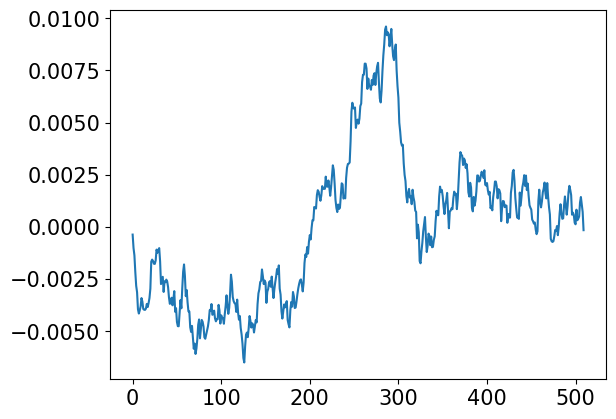

C:\Users\zimme\AppData\Local\Temp\ipykernel_1308\3161495930.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.semilogx(f,10*np.log10(1e-7/f**2/4))


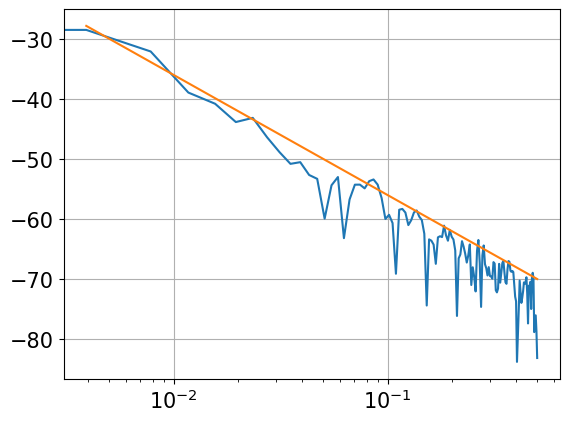

In [4]:
nt=256
x=np.arange(nt).reshape(-1,1)
x[0]=1
n=np.random.rand(nt,1)
c=np.exp(2*np.pi*1j*n)/x
c[0,0]=0
h=np.fft.irfft(c,axis=0)

plt.plot(h)
plt.show()
f,p=signal.welch(h,axis=0)
plt.semilogx(f,10*np.log10(p))
plt.semilogx(f,10*np.log10(1e-7/f**2/4))
plt.grid(True)
plt.show()

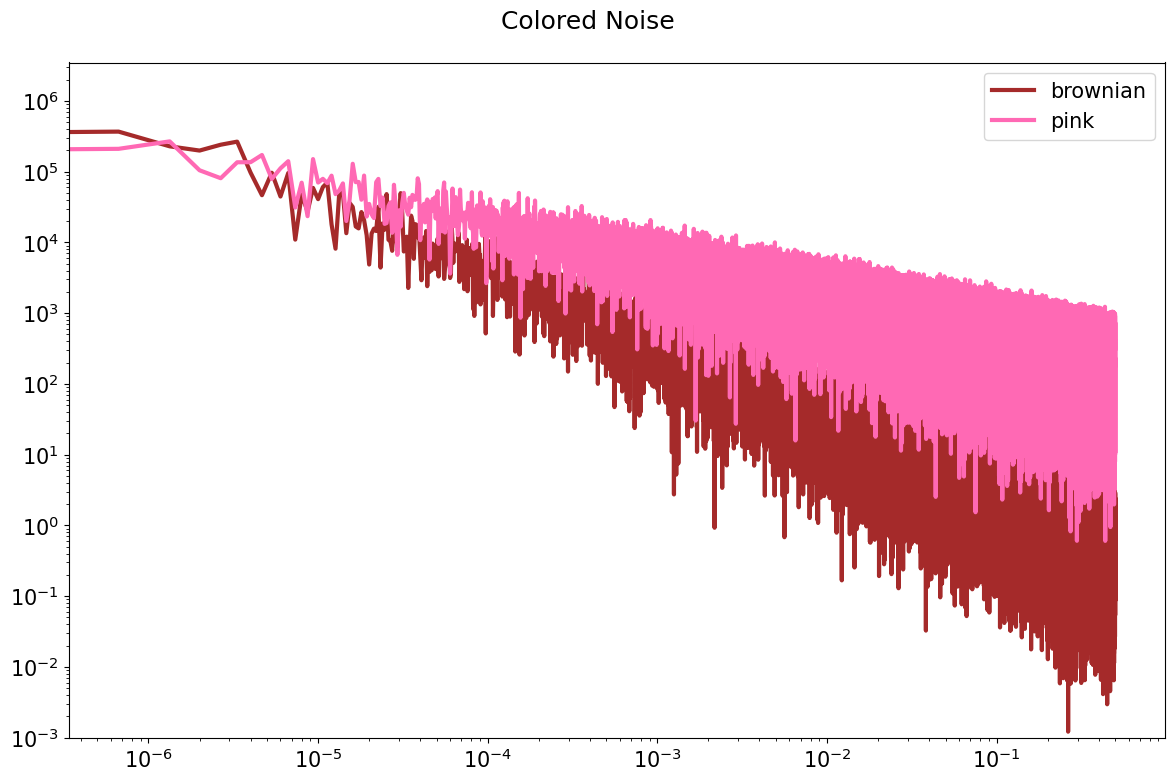

In [5]:
#https://stackoverflow.com/questions/67085963/generate-colors-of-noise-in-python

import numpy as np
import matplotlib.pyplot as plt

def plot_spectrum(s):
    f = np.fft.rfftfreq(len(s))
    return plt.loglog(f, np.abs(np.fft.rfft(s)))[0]

def noise_psd(N, psd = lambda f: 1):
        X_white = np.fft.rfft(np.random.randn(N));
        S = psd(np.fft.rfftfreq(N))
        # Normalize S
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S;
        return np.fft.irfft(X_shaped);

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def brownian_noise(f):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def pink_noise(f):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

#
plt.figure(figsize=(12, 8), tight_layout=True)
for G, c in zip(
        [brownian_noise, pink_noise], 
        ['brown', 'hotpink']):
    plot_spectrum(G(30*50_000)).set(color=c, linewidth=3)
plt.legend(['brownian', 'pink'])
plt.suptitle("Colored Noise");
plt.ylim([1e-3, None]);
plt.show()


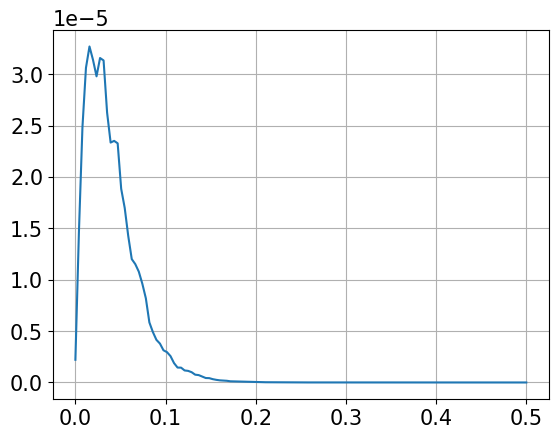

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

def shipNoise(N):
    N2 = N//2+1
    f = np.arange(0,N2)/20
    A2 = np.sqrt(f*np.exp(-f))
    A2 /= np.sqrt(np.sum(A2**2))
    n2 = np.random.random(N2)
    p2 = 2*np.pi*(n2-0.5)
    d2 = A2*np.exp(1j*p2)
    #
    x = np.fft.irfft(d2)
    return x

xx=np.hstack((shipNoise(1024),shipNoise(1024),shipNoise(1024),shipNoise(1024)))
f,P= signal.welch(xx,axis=0)
plt.plot(f,P)
plt.grid(True)
plt.show()

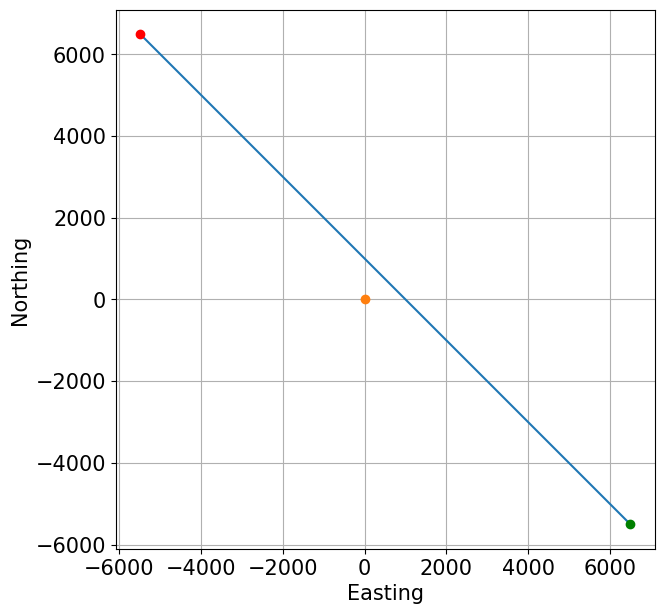

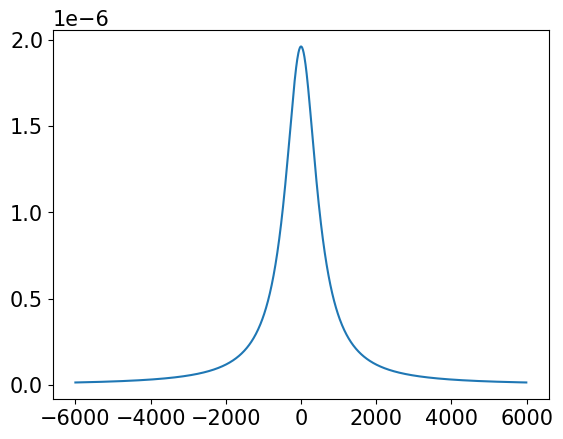

In [7]:
it=np.arange(-6000,6000,10).reshape(-1,1)           # in time in seconds
vv=np.array([-1,1,0])                               # speed in m/s
cp = np.array([500,500,0])                          # closest point of approach
ro = np.array([0,0,-100])                           # recorder location
ss = (cp-ro)+vv*it                                  # relative source location
rr=np.sum(ss**2,1)
plt.figure(figsize=(7,7))
plt.plot(ss[:,0],ss[:,1])
plt.plot(0,0,'o')
plt.plot(ss[0,0],ss[0,1],'go')
plt.plot(ss[-1,0],ss[-1,1],'ro')
plt.grid(True)
plt.gca().set_aspect('equal')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.show()
plt.plot(it,1/rr)
plt.show()

In [8]:
nfft=256
M=np.zeros((nfft//2+1,len(it)))
for nn in range(len(it)):
    xx=shipNoise(1024)
    for ii in range(100):
        xx=np.append(xx,shipNoise(1024))
    xx *= 1e+9/rr[nn]
    if nn%100 ==0: print(nn,xx.std())
    f,P=signal.welch(xx,nfft=nfft,fs=96000,axis=0)
    M[:,nn]=P



0 0.019046585739898675
100 0.027342465491983194
200 0.04248132673023609
300 0.07461198984331935
400 0.1622876535840148
500 0.5502262677289815
600 2.707976337254743
700 0.550226267729013
800 0.16228765358403116
900 0.07461198984332253
1000 0.04248132673023027
1100 0.027342465491978114


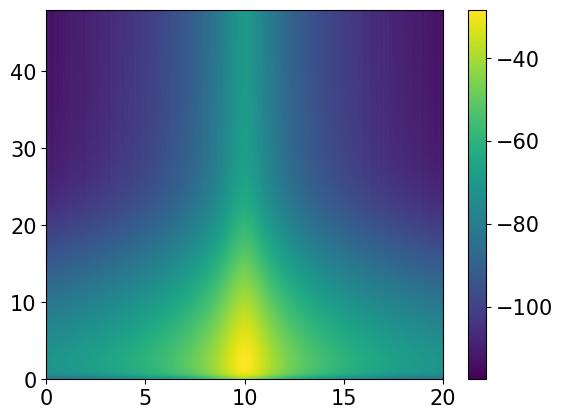

In [9]:
plt.imshow(10*np.log10(M),aspect='auto',origin='lower',extent=[0,20,f[0]/1000,f[-1]/1000])
plt.colorbar()
plt.show()


1.4142135623730951
[0.145 0.145 0.145 0.145 0.145 0.145] m
[5.17241379 5.17241379 5.17241379 5.17241379 5.17241379 5.17241379] kHz


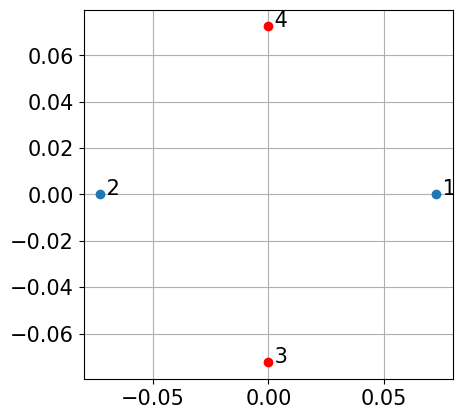

In [10]:
#hydrophone configuration
dz=np.sqrt(0.5)
print(2*dz)
ho=np.array([[1,0,-dz],[-1,0,-dz],[0,-1,dz],[0,1,dz]])*0.0725

hsel=np.array([[1,0],[2,0],[3,0],[2,1],[3,1],[3,2]])
nc=hsel.shape[0]
D=ho[hsel[:,0],:]-ho[hsel[:,1],:]
L=np.sqrt(np.sum(D**2,1))
print(L,'m')
print(0.75/L, 'kHz')
DI=np.linalg.pinv(D)
#
plt.plot(ho[:2,0],ho[:2,1],'o')     # bottom
plt.plot(ho[2:,0],ho[2:,1],'ro')    # top
plt.text(ho[0,0],ho[0,1],' 1')
plt.text(ho[1,0],ho[1,1],' 2')
plt.text(ho[2,0],ho[2,1],' 3')
plt.text(ho[3,0],ho[3,1],' 4')
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()


In [11]:
# Overlap-add FIR filter, (c) Joachim Thiemann 2016
# https://github.com/jthiem/overlapadd/blob/master/olafilt.py
#
# modified by WMXZ to work on multi-channel data
#
def fft_filt(b, x, zi=None, nh=0):
    """
    Filter a one-dimensional array with an FIR filter

    Filter a data sequence, `x`, using a FIR filter given in `b`.
    Filtering uses the overlap-add method converting both `x` and `b`
    into frequency domain first.  The FFT size is determined as the
    next higher power of 2 of twice the length of `b`.

    Parameters
    ----------
    b : one-dimensional numpy array
        The impulse response of the filter
    x : one-dimensional numpy array
        Signal to be filtered
    zi : one-dimensional numpy array, optional
        Initial condition of the filter, but in reality just the
        runout of the previous computation.  If `zi` is None or not
        given, then zero initial state is assumed.
    nh : time shift of result (group delay)

    Returns
    -------
    y : array
        The output of the digital filter.
    zf : array, optional
        If `zi` is None, this is not returned, otherwise, `zf` holds the
        final filter delay values.
    """

    if x.ndim==1: x=x.reshape(-1,1)
    if b.ndim==1: b=b.reshape(-1,1)
    L_I = b.shape[0]
    # Find power of 2 larger that 2*L_I (from abarnert on Stackoverflow)
    L_F = 2<<(L_I-1).bit_length()
    L_S = L_F - L_I + 1
    L_sig,N_sig = x.shape
    offsets = range(0, L_sig, L_S)

    # handle complex or real input
    if np.iscomplexobj(b) or np.iscomplexobj(x):
        fft_func = np.fft.fft
        ifft_func = np.fft.ifft
        res = np.zeros((L_sig+L_F,N_sig), dtype=np.complex128)
    else:
        fft_func = np.fft.rfft
        ifft_func = np.fft.irfft
        res = np.zeros((L_sig+L_F,N_sig))

    FDir = fft_func(b, n=L_F,axis=0)

    # overlap and add
    for n in offsets:
        res[n:n+L_F,:] += ifft_func(fft_func(x[n:n+L_S,:], n=L_F,axis=0)*FDir,axis=0)

    if zi is not None:
        res[:zi.shape[0],:] = res[:zi.shape[0],:] + zi
        zi=res[L_sig:,:]
        return res[nh:nh+L_sig,:],zi 
    else:
        return res[nh:nh+L_sig,:]

def sim_array(yy,fs,DT1,noise):
    # delay signal according to array geometry 
    # (use fractional delay with sinc function)
    kk=np.arange(-10,10,1);
    ss=np.zeros((len(yy),len(DT1)))
    for ii in range(len(DT1)):
        hh=np.sinc(kk+DT1[ii]*fs/1000)
        ss[:,ii]=fft_filt(hh,yy)[:,0]

    nn=np.random.normal(scale=noise, size=ss.shape)
    ss +=nn
    return ss

#from numba import jit, int32, uint32, int64, float64, types
# @jit((types.Array(float64, 1, "C"), 
#      int64,
#      int64,
#      types.Array(float64, 1, "C"), 
#      types.Array(float64, 1, "C")),nopython=True,cache=True)
def intensity(yy,fs,nfft,hsel,DI):
    nc=hsel.shape[0]
    f,t,Q=signal.stft(yy,fs=fs,nperseg=nfft,noverlap=nfft//2,nfft=nfft,axis=0)
    #
    n1,n2,n3=Q.shape        # nfr,nch,nsmp
    C=np.zeros((n1,n3,nc))
    for ii in range(nc):
        C[:,:,ii] = np.imag(Q[:,hsel[ii,0],:]*np.conjugate(Q[:,hsel[ii,1],:]))
    #
    # # 3-d summation
    I=-C@DI.T
    return f,t,I

nfft=256
fs=96000
M=np.zeros((nfft//2+1,len(it),3))
for nn in range(len(it)):
    #
    ## simulate delay
    S=-ss[nn,:]/np.sqrt(rr[nn])
    DC=np.sum(ho*S,1)
    DT=DC/1.500   # ms
    #
    xx=shipNoise(1024)
    for ii in range(100):
        xx=np.append(xx,shipNoise(1024))
    xx *= 1e+9/rr[nn]
    #
    sn=0.1
    yy=sim_array(xx,fs,DT,sn)[10:fs+10,:]
    if nn%100 ==0: print(nn,xx.std(),yy.std(),20*np.log10(xx.std()/sn))

    #print(yy.dtype,type(fs),type(nfft),hsel.dtype,DI.dtype)
    f,t,I = intensity(yy,fs,nfft,hsel,DI)

    M[:,nn,:]=np.mean(I,1)
#
# adress zero and nyquist frequency
M[ 0,:,:] = M[ 1,:,:]
M[-1,:,:] = M[-2,:,:]

0 0.019046585739898397 0.10163338119642568 -14.403657278733771
100 0.02734246549197834 0.1036434792416086 -11.263246546435806
200 0.04248132673024236 0.108605714349713 -7.4360385661091275
300 0.07461198984333076 0.12484530580079932 -2.5438275512454744
400 0.16228765358401653 0.19066496664318286 4.205709622120401
500 0.5502262677290918 0.5588090281589649 14.810826394191645
600 2.7079763372545345 2.709166305683099 28.652897301852374
700 0.5502262677290397 0.5604832196649147 14.810826394190823
800 0.16228765358400313 0.19059966257842667 4.2057096221196835
900 0.07461198984333099 0.12481188224989272 -2.5438275512454473
1000 0.04248132673024403 0.10867656038655965 -7.4360385661087856
1100 0.02734246549197672 0.10378133391728128 -11.26324654643632


In [12]:
M[ 0,:,:] = M[ 1,:,:]
M[-1,:,:] = M[-2,:,:]
Mn=np.sqrt(np.sum(M**2,2))
#
K=M/Mn.reshape(M.shape[0],M.shape[1],1)

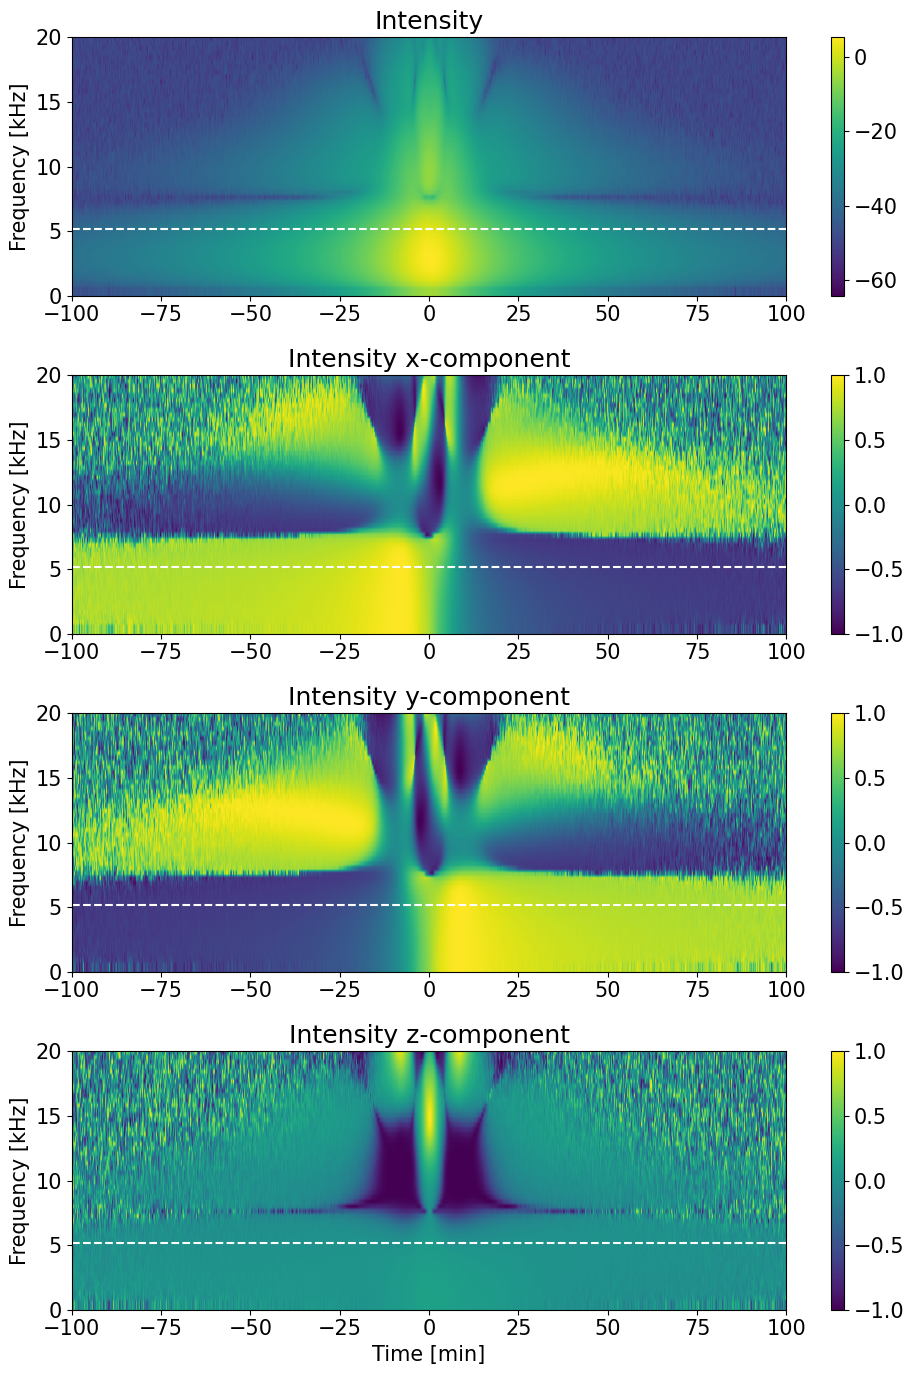

In [13]:
tx=np.array([-6000,6000])/60            # minutes
yl=[0,20]
plt.figure(figsize=(10,14),layout='tight')
plt.subplot(411)
plt.imshow(10*np.log10(Mn),aspect='auto',origin='lower',extent=[tx[0],tx[1],f[0]/1000,f[-1]/1000])
plt.hlines(np.min(0.75/np.max(L)),tx[0],tx[1],colors='w',linestyles='--')
plt.ylim(yl)
plt.colorbar()
plt.ylabel('Frequency [kHz]')
plt.title('Intensity')

plt.subplot(412)
plt.imshow(K[:,:,0],aspect='auto',origin='lower',extent=[tx[0],tx[1],f[0]/1000,f[-1]/1000],clim=[-1,1])
plt.hlines(np.min(0.75/np.max(L)),tx[0],tx[1],colors='w',linestyles='--')
plt.ylim(yl)
plt.colorbar()
plt.ylabel('Frequency [kHz]')
plt.title('Intensity x-component')

plt.subplot(413)
plt.imshow(K[:,:,1],aspect='auto',origin='lower',extent=[tx[0],tx[1],f[0]/1000,f[-1]/1000],clim=[-1,1])
plt.hlines(np.min(0.75/np.max(L)),tx[0],tx[1],colors='w',linestyles='--')
plt.ylim(yl)
plt.colorbar()
plt.ylabel('Frequency [kHz]')
plt.title('Intensity y-component')

plt.subplot(414)
plt.imshow(K[:,:,2],aspect='auto',origin='lower',extent=[tx[0],tx[1],f[0]/1000,f[-1]/1000],clim=[-1,1])
plt.hlines(np.min(0.75/np.max(L)),tx[0],tx[1],colors='w',linestyles='--')
plt.ylim(yl)
plt.colorbar()
plt.ylabel('Frequency [kHz]')
plt.title('Intensity z-component')
plt.xlabel('Time [min]')
plt.show()

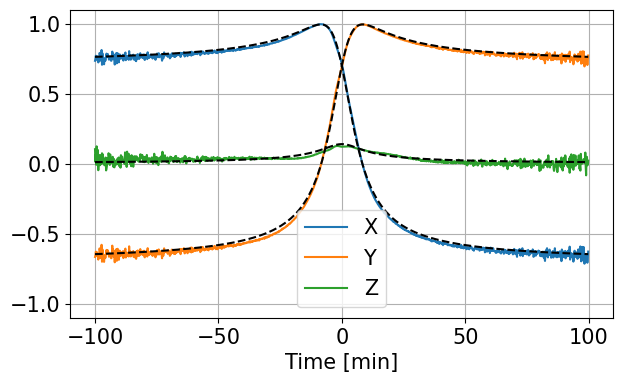

In [14]:
k1=int(2/96*256)
k2=int(4/96*256)
K2=np.mean(K[k1:k2,:,:],axis=0)
plt.figure(figsize=(7,4))
plt.plot(it/60,K2,label=['X','Y','Z'])
plt.plot(it/60,ss/np.sqrt(rr).reshape(-1,1),'k--')
plt.ylim(-1.1,1.1)
plt.xlabel('Time [min]')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
print(xx.std(),np.std(yy),np.std(shipNoise(1024)))

0.019109784281763305 0.10184302078578476 0.0013810679319994656
